In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sounddevice as sd
from scipy.io import wavfile
from scipy import signal
import scipy
from pydub import AudioSegment

In [17]:
f = 'data/povezlo-povezlo.wav'

samplerate, data = wavfile.read(f)
print('Sampling Rate:',samplerate)
print('Audio Shape:',np.shape(data))

Sampling Rate: 44100
Audio Shape: (80640, 2)


In [18]:
duration = len(data)/samplerate
time = np.arange(0,duration,1/samplerate) #time vector
print(f"длительность {duration} \n временная шкала {time}")


длительность 1.8285714285714285 
 временная шкала [0.00000000e+00 2.26757370e-05 4.53514739e-05 ... 1.82850340e+00
 1.82852608e+00 1.82854875e+00]


In [19]:
type(data)

numpy.ndarray

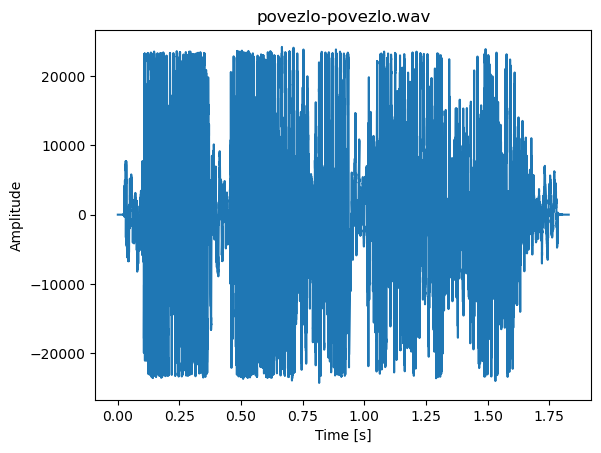

In [20]:
plt.plot(time, data[:, 0])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('povezlo-povezlo.wav')
plt.show()

In [21]:
# слушаем, что получилось
sd.play(data[:, 0], samplerate)
sd.wait()

Sampling Rate: 44100
Audio Shape: (80640,)


C:\Users\kanze\AppData\Local\Temp\ipykernel_20700\2500143426.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(t,a,'k-',color='purple')


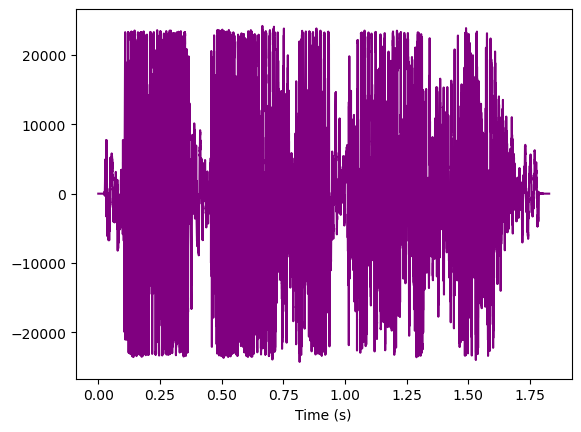

In [22]:
asegment = AudioSegment.from_wav(f)
asegment = asegment.set_channels(1)
asegment.export("mono.wav",format="wav")
s,a = wavfile.read("mono.wav")

print('Sampling Rate:',s)
print('Audio Shape:',np.shape(a))
duration = len(data)/samplerate
time = np.arange(0,duration,1/samplerate)
na = data.shape[0]
la = na / s
t = np.linspace(0,la,na)
plt.plot(t,a,'k-',color='purple')
plt.xlabel('Time (s)')
plt.show()

C:\Users\kanze\AppData\Local\Temp\ipykernel_20700\3049010311.py:4: RuntimeWarning: divide by zero encountered in log
  lspg = np.log(spgram)


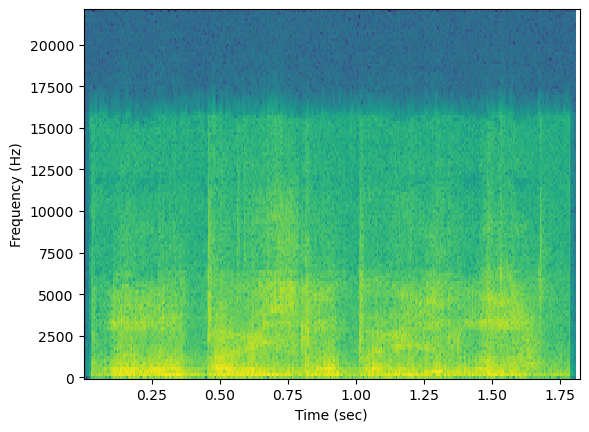

In [23]:
adata = data[:, 0]
s = samplerate
fr, tm, spgram = signal.spectrogram(adata,s)
lspg = np.log(spgram)
plt.pcolormesh(tm,fr,lspg,shading='auto')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.show()

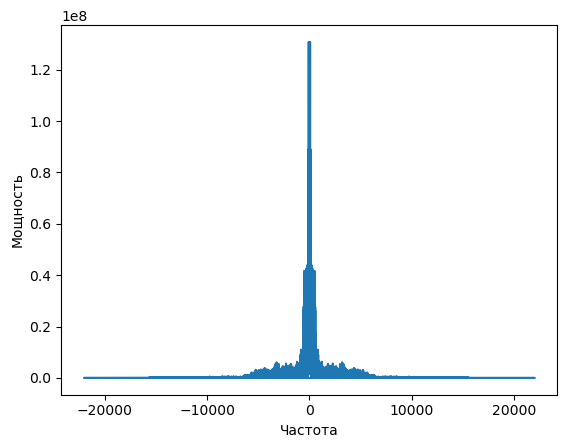

In [24]:
from scipy.fft import fft, fftfreq

N = int(samplerate * duration)
yf = fft(data[:, 0])
xf = fftfreq(N, 1 / samplerate)
plt.plot(xf, np.abs(yf))
plt.xlabel('Частота')
plt.ylabel('Мощность')
plt.show()

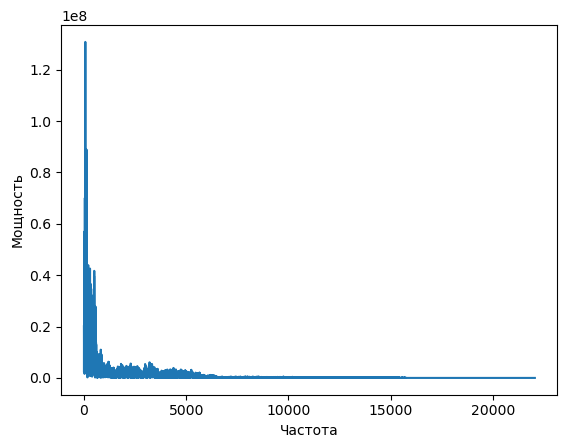

In [25]:
from scipy.fft import rfft, rfftfreq

rN = int(samplerate * duration)
ryf = rfft(data[:, 0])
rxf = rfftfreq(rN, 1 / samplerate)
plt.plot(rxf, np.abs(ryf))
plt.xlabel('Частота')
plt.ylabel('Мощность')
plt.show()

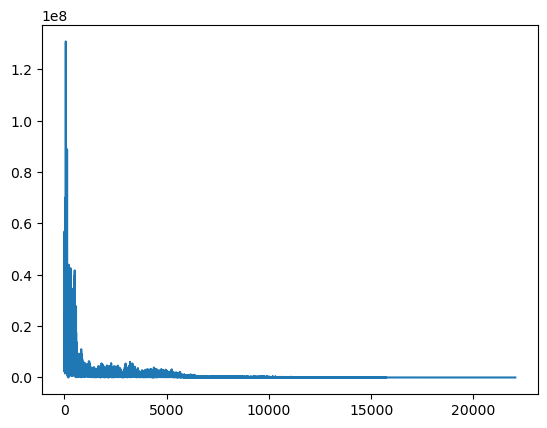

In [26]:
points_per_freq = len(rxf) / (samplerate / 2)

target_idx = int(points_per_freq * 200)

target_idx1 = int(points_per_freq * 10000)

ryf[target_idx-2:target_idx+2] = 0
plt.plot(rxf, np.abs(ryf))
plt.show()

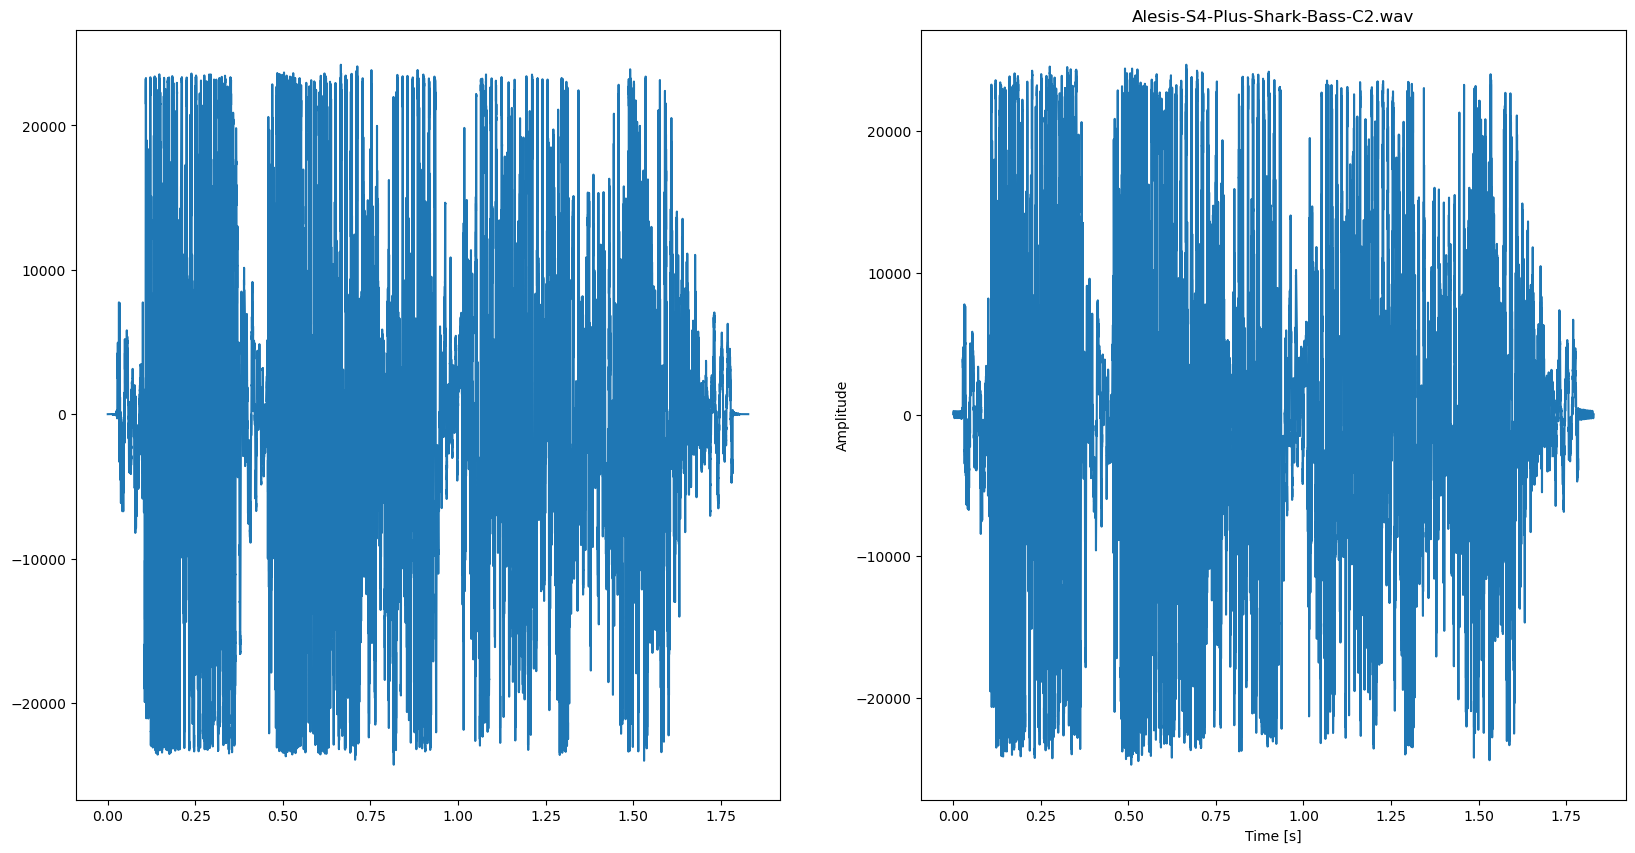

In [27]:
from scipy.fft import irfft
new_sig = irfft(ryf)
fig, ax = plt.subplots(nrows= 1 , ncols= 2, figsize=(20, 10))

ax[0].plot(time, data[:, 0])
ax[1].plot(time[:len(new_sig)], new_sig)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Alesis-S4-Plus-Shark-Bass-C2.wav')
plt.show()

In [28]:
def B_inv(b):
    return 700 * (np.exp(b / 1125) - 1)

def B(b):
    return 1125 * np.log(1 + b / 700)

def get_filter_points(fmin, fmax, mel_filter_num, wav_size, sample_rate=44100):    
    mels = np.linspace(B(fmin), B(fmax), num=mel_filter_num + 2)
    freqs = B_inv(mels)
    
    return np.floor((wav_size + 1) / sample_rate * freqs).astype(int)

def H(k, m, f):
    if k >= f[m - 1] and k < f[m]:
        return (k - f[m - 1]) / (f[m] - f[m - 1])
    if k >= f[m] and k <= f[m + 1]:
        return (f[m + 1] - k) / (f[m + 1] - f[m])
    return 0

In [29]:
from scipy.fft import fft

x = data[:, 0]
X = scipy.fft.fft(adata)
M = 30
N = len(X)

filters_points = get_filter_points(0, samplerate / 2, M, N)

S = []

for m in range(1, M + 1):
    Si = 0
    for k in range(N - 1):
        Si += (np.abs(X[k]) ** 2) * H(k, m, filters_points)
    S += [np.log(Si)]
print(S)

[39.166432774780084, 38.641674428178035, 38.363125662936135, 38.177622984600575, 38.40805195774368, 36.68972687799888, 35.91193928566383, 35.27523220813053, 35.39260339493879, 34.860619856243495, 35.146938771517384, 35.288810884642395, 35.35775588429902, 35.11235816665399, 35.53659514629072, 35.276015325912994, 35.01059646460654, 35.079356006377246, 34.802399388544124, 33.75767302680526, 32.20161154440933, 31.691775921654266, 31.60051161162189, 31.38477552766319, 30.545063909987224, 29.502083242166346, 29.253779233159616, 28.466982429970493, 23.335784079386322, 17.32227401235607]


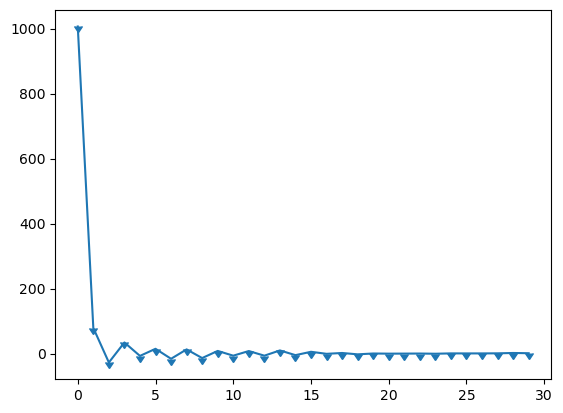

In [30]:
c = []


for n in range(M):
    ci = 0
    for m in range(M):
        ci += S[m] * np.cos(np.pi * n * (m + 0.5) / M)
    c += [ci]

plt.plot(c,marker=matplotlib.markers.CARETDOWNBASE)